### SI analysis

In [2]:
%run -m setup

#### (1) Possible biases in population abundances dataset
The biomass of wild land mammal species missing global population reports was estimated using regression models. Our two regression models were built using a population abundances dataset, and are nearly identical, the only difference being one of the input features. For species whose body mass is over 1 kg, we use range size as one of the input features. </br>
This feature is not used as an input for species with a body mass of below 1 kg- the threshold was determined due to the lack of small bodied mammals that reside over large ranges in our population abundances dataset, as shown below

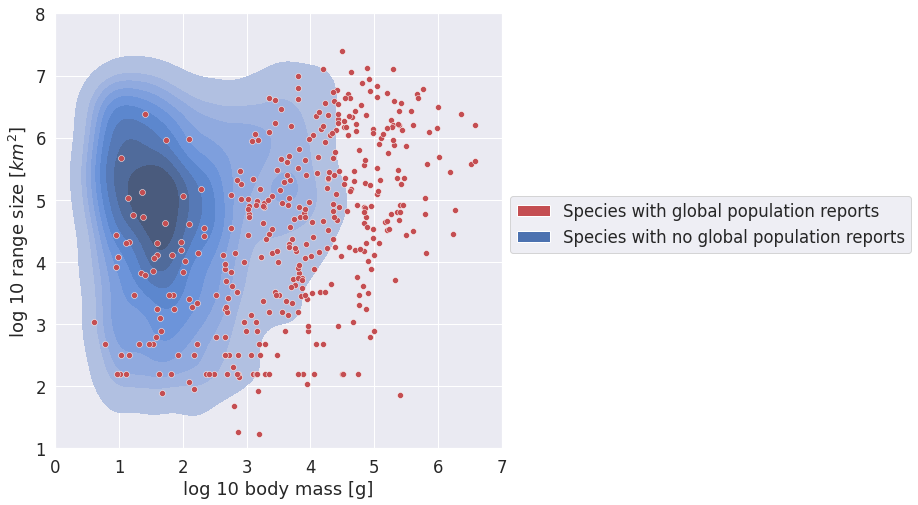

In [3]:
all_species_list = pd.read_csv(path_to_data+'all_species_list.csv')
to_infer = pd.read_csv(path_to_data+'species_to_infer_w_ranges.csv')
training = pd.read_csv(path_to_data+'species_w_pop_reports_w_ranges.csv')
training = training.assign(log10_bm = np.log10(training.AdultBodyMassG), log10_range = np.log10(training.Range_km_2))
to_infer = to_infer.assign(log10_bm = np.log10(to_infer.AdultBodyMassG), log10_range = np.log10(to_infer.Range_km_2))


sns.set_theme()
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(1, 1,figsize=(8, 8))
to_infer_plt = sns.kdeplot(data = to_infer, x = 'log10_bm', y = 'log10_range', thresh = 0.05, fill = True, ax=ax, label = "without pop reports")
to_infer_plt = sns.scatterplot(data = training, x = 'log10_bm', y = 'log10_range', color = sns.color_palette()[3], label = "with pop reports")
to_infer_plt.set(ylim=(1, 8), xlim = (0,7), xlabel = 'log 10 body mass [g]',ylabel = r'log 10 range size [$km^{2}$]')
handles = [mpatches.Patch(facecolor=sns.color_palette()[3], label="Species with global population reports"),
           mpatches.Patch(facecolor=sns.color_palette()[0], label="Species with no global population reports")]
plt.legend(handles=handles, bbox_to_anchor=(1., 0.6))
plt.savefig(path_to_SI_plots+'possible_biases.png',bbox_inches='tight')

#### (2) Confidence intervals in reported population abundances
Produce SI figure- find species reports that came with confidence intervals 

In [4]:
def find_range(pop_estimate):
    if type(pop_estimate)==str and '-' in pop_estimate:
        return pop_estimate
    else:
        return 0

def find_all_ranges(pop_ranges):
    if type(pop_ranges.CI_1)==str:
        return pop_ranges.CI_1
    elif type(pop_ranges.CI_2)==str:
        return pop_ranges.CI_2
    else:
        return 0
    
def remove_redundant_charachters(pop_series):
    pop_series = pop_series.str.replace(',|<|>|~','',regex=True)
    pop_series = pop_series.str.replace('common locally|rare|extinct','0',regex=True)
    pop_series = pop_series.str.replace('*','0',regex=True)
    pop_series = pop_series.apply(replace_range_w_value)
    pop_series = pop_series.astype(float)
    pop_series = pop_series.fillna(0)
    return pop_series
    
def replace_range_w_value(val):
    if type(val)==str and '-' in val:
        lower, upper = val.split('-')
        mean_ = np.mean([float(lower),float(upper)])
        return float(lower),float(upper),mean_


manually_curated_data = pd.read_csv(path_to_marine_data+'/manually_curated_data.csv')
manually_curated_data['binomial']=manually_curated_data['Genus']+' '+manually_curated_data['Species']
species_names = pd.read_csv(path_to_data+'species_w_pop_reports.csv')
species = np.array(species_names['binomial'])
terrestrial_df = manually_curated_data[manually_curated_data['binomial'].isin(species)]
terrestrial_df = terrestrial_df.assign(CI_1 = terrestrial_df['Extracted total population'].apply(find_range))
terrestrial_df = terrestrial_df.assign(CI_2 = terrestrial_df['Extracted total population.1'].apply(find_range))
terrestrial_df = terrestrial_df.assign(CI = terrestrial_df[['CI_1','CI_2']].apply(find_all_ranges, axis = 1))
terrestrial_df = terrestrial_df[terrestrial_df['CI']!=0]
terrestrial_df = terrestrial_df[['binomial','CI']].sort_values(by = 'binomial')
terrestrial_df['CI'] = terrestrial_df['CI'].str.replace(',|<|>|~| ','',regex=True)
terrestrial_df = terrestrial_df.assign(CI_as_tuple = terrestrial_df['CI'].apply(replace_range_w_value))
terrestrial_df = terrestrial_df.assign(lower = terrestrial_df.CI_as_tuple.map(lambda x:x[0]),
                                       upper = terrestrial_df.CI_as_tuple.map(lambda x:x[1])).drop(['CI_as_tuple'], axis = 1)
                                       
terrestrial_df = terrestrial_df[terrestrial_df.lower>5]

terrestrial_df = terrestrial_df[terrestrial_df.binomial!='Macropus giganteus']
terrestrial_df = terrestrial_df[terrestrial_df.binomial!='Sylvicapra grimmia']

wild_land_mammal_biomass = pd.read_csv(path_to_results+'wild_land_mammal_biomass.csv')
top =  terrestrial_df.merge(wild_land_mammal_biomass[['binomial','biomass_Mt']], on = 'binomial').sort_values(by = 'biomass_Mt', ascending = False).iloc[0:20]
common_names = pd.read_csv(path_to_data+'common_names.csv')
top = top.merge(common_names, on = 'binomial')
top[['binomial','common_name','CI']].to_csv(path_to_SI_plots+'reported_CIs.csv')
top[['binomial','common_name','CI']]

binomial  \
0            Syncerus caffer   
1              Lama guanicoe   
2               Equus quagga   
3     Hippopotamus amphibius   
4   Tragelaphus strepsiceros   
5                  Kobus kob   
6     Antidorcas marsupialis   
7           Tragelaphus oryx   
8           Ovibos moschatus   
9       Tragelaphus scriptus   
10            Capra sibirica   
11        Procapra gutturosa   
12               Equus kiang   
13   Boselaphus tragocamelus   
14                Lynx rufus   
15               Bison bison   
16       Hippotragus equinus   
17       Damaliscus pygargus   
18           Pan troglodytes   
19                Bos gaurus   

                                          common_name               CI  
0                                     African Buffalo    398000-401000  
1                                             Guanaco  1000000-1500000  
2   Plains Zebra, Burchell's Zebra, Common Zebra, ...    150000-250000  
3      Hippopotamus, Common Hippopotamus, Large Hippo    115000-130000  
4                                        Greater Kudu    300000-350000  
5                                                 Kob   500000-1000000  
6                                           Springbok  2000000-2500000  
7                                 Common Eland, Eland     90000-110000  
8                                     Muskox, Musk Ox    133914-136914  
9                                            Bushbuck  1000000-1500000  
10        Siberian Ibex, Asiatic Ibex, Himalayan Ibex    234153-255153  
11                          Mongolian Gazelle, Dzeren   500000-1500000  
12                                              Kiang      60000-70000  
13                                   Nilgai, Bluebuck     70000-100000  
14                                   Bobcat, Bay Lynx  2352276-3571681  
15                                     American Bison      11248-13123  
16                                      Roan Antelope      50000-60000  
17                                  Blesbok, Bontebok    238500-243500  
18   Chimpanzee, Common Chimpanzee, Robust Chimpanzee    345000-470000  
19                                 Gaur, Indian Bison       6000-21000

In [5]:
small_bodied_species = to_infer[to_infer.AdultBodyMassG<1000].binomial
large_bodied_species = to_infer[~to_infer.binomial.isin(small_bodied_species)].binomial

#### (3) Temporal sensitivity analysis


In [16]:
manually_curated_data = pd.read_csv(path_to_marine_data+'manually_curated_data.csv')
wild_terrestrial = pd.read_csv(path_to_data+'all_species_list.csv')
biomass_pred = pd.read_csv(path_to_results+'combined_model_results.csv')


pop_trends_data = manually_curated_data.copy()
pop_trends_data['binomial'] = pop_trends_data['Genus']+' '+ pop_trends_data['Species']
wild_terrestrial = wild_terrestrial.merge(pop_trends_data,on = 'binomial', how = 'left')[['binomial','Population trend','Year assessed']]
na_vals = ['3.1',' D']
wild_terrestrial = wild_terrestrial[~wild_terrestrial['Year assessed'].isin(na_vals)].dropna()

In [17]:
biomass_pred = pd.read_csv(path_to_results+'combined_model_results.csv')
biomass_by_trend = wild_terrestrial.merge(biomass_pred, on = 'binomial')
biomass_by_trend['n_species']=1
grouped = biomass_by_trend.groupby('Population trend').sum()[['biomass_Mt','n_species']].reset_index()
grouped['biomass_Mt_norm'] = grouped['biomass_Mt']/grouped['biomass_Mt'].sum()
grouped['n_species_norm'] = grouped['n_species']/grouped['n_species'].sum()

Plot the SI figure

65% of species were assessed in the past 5 years


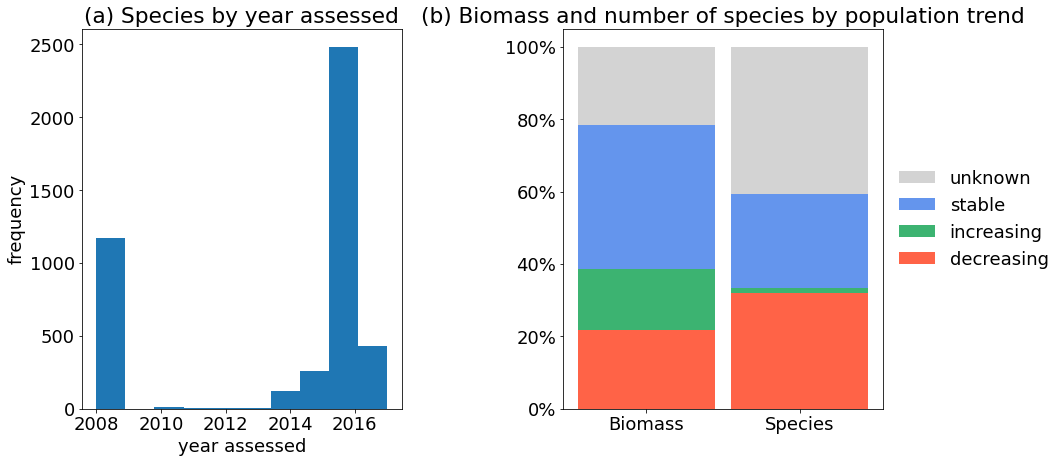

In [18]:
font = {'size'   : 18}
plt.rc('font', **font)
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.tight_layout()
fig.set_size_inches(14, 7)

column_names = ['Biomass', 'Species']
columns = ['biomass_Mt_norm','n_species_norm']

colors = ['tomato','mediumseagreen','cornflowerblue','lightgrey']
prev = [0,0]
for category in range(0,len(grouped)):
    axes[1].bar(column_names,grouped.iloc[category][columns], bottom = prev,label=grouped.iloc[category]['Population trend'], width = 0.9, color = colors[category])
    prev = grouped.iloc[category][columns]+prev

axes[1].set_title('(b) Biomass and number of species by population trend')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False, labelspacing=-2.5)
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(1))

biomass_by_trend['Year assessed'] = biomass_by_trend['Year assessed'].astype(int)
axes[0].hist(biomass_by_trend['Year assessed'])
axes[0].set_xlabel('year assessed')
axes[0].set_ylabel('frequency')
axes[0].set_title('(a) Species by year assessed')
plt.savefig(path_to_SI_plots+'population_trend+assesment_year.png',bbox_inches='tight')
last_5_years = round((len(biomass_by_trend[biomass_by_trend['Year assessed']>2015])/len(biomass_by_trend['Year assessed']))*100)
print(str(last_5_years)+'% of species were assessed in the past 5 years')
plt.show()

In [6]:
def get_years(txt):
    lst = re.findall(r'\d+ years', txt)
    return lst

def get_percent(txt):
    lst = re.findall(r'\d+%', txt)
    return lst

def get_num(lst):
    nums = [int(re.findall(r'\d+', txt)[0]) for txt in lst]
    if len(nums)>0:
        nums = sum(nums) / len(nums)
        return nums
    else:
        return
    
def yearly_decline(percent,years):
    return ((100/(100+percent))**(1/years)-1)*100

def total_change(years,yearly_change_frac):
    value = 1
    for i in range(0,years):
        value = value*(1+yearly_change_frac)
    return round(value,2)

def find_percent(txt):
    lst = re.findall(r'%', txt)
    return lst

def get_mean(txt):
    lst = re.findall(r'\d+\.\d+', txt)
    return float(lst[0])

def calculate_biomass_change(trends, yearly_frac):
    species_df = wild_terrestrial[wild_terrestrial['Population trend'].isin(decreasing_trends)]
    species_df = species_df.assign(years_diff = 2021-species_df['Year assessed'].astype(int))
    species_df = species_df.assign(fraction_currently = species_df['years_diff'].apply(total_change, args = (yearly_frac,)))
    species_df = species_df.merge(biomass_pred, on = 'binomial', how  = 'inner')
    species_df['biomass_after_time'] = species_df['biomass_Mt']*species_df['fraction_currently']
    tot_biomass_before_change = round(biomass_by_trend.biomass_Mt.sum())
    biomass_after_change = round(species_df['biomass_after_time'].sum())
    tot_biomass_after_change = round(biomass_by_trend[~biomass_by_trend['Population trend'].isin(decreasing_trends)].biomass_Mt.sum()+biomass_after_change)
    percent_bm_change = round(((tot_biomass_after_change-tot_biomass_before_change)/tot_biomass_before_change)*100)
    print('estimated_biomass before applying temporal trend: '+ str(tot_biomass_before_change))
    print('estimated_biomass after applying temporal trend: '+ str(tot_biomass_after_change))
    print('diff from estimate: '+ str(percent_bm_change)+'%')

Plot the SI figure

Average yearly decline: 7%
estimated_biomass before applying temporal trend: 25
estimated_biomass after applying temporal trend: 20
diff from estimate: -20%



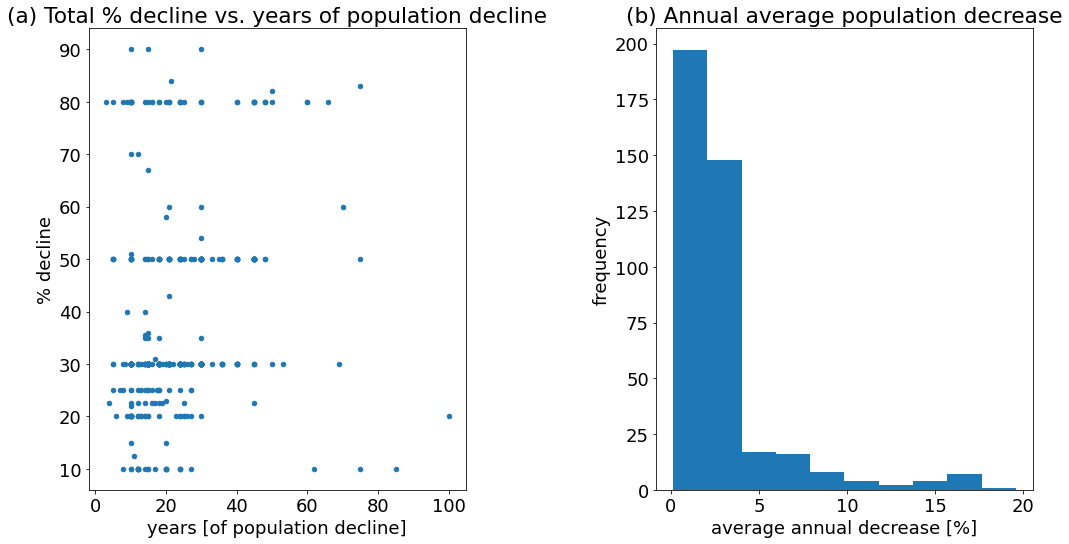

In [20]:
manually_curated_data['binomial'] = manually_curated_data['Genus']+' '+ manually_curated_data['Species']
decline_df = manually_curated_data[['binomial','Extracted population decline', 'Population decline years']].dropna()
decline_df['decline_percent'] = decline_df['Extracted population decline'].apply(get_percent)
decline_df['decline_years'] = decline_df['Population decline years'].apply(get_years)
decline_df['decline_percent_nums'] = decline_df['decline_percent'].apply(get_num)
decline_df['decline_years_nums'] = decline_df['decline_years'].apply(get_num)
decline_df = decline_df.dropna()
decline_df['yearly_decline'] = decline_df.apply(lambda x: yearly_decline(-x.decline_percent_nums,x.decline_years_nums), axis = 1)
prec_90_decline = decline_df['yearly_decline'].quantile(0.9)
yearly_decline_frac = round(prec_90_decline/100,2)
print('Average yearly decline: '+str(round(yearly_decline_frac*100))+'%')

decreasing_trends = ['decreasing','unknown']
calculate_biomass_change(decreasing_trends, -yearly_decline_frac)

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.tight_layout()
fig.set_size_inches(16.5, 8.5)

decline_df.plot.scatter(x = 'decline_years_nums',y = 'decline_percent_nums',xlabel = 'years [of population decline]', ylabel = '% decline',ax=axes[0], title = '(a) Total % decline vs. years of population decline')

axes[1].hist(decline_df[decline_df['yearly_decline']<20]['yearly_decline'])
print('')
plt.xlabel('average annual decrease [%]')
plt.ylabel('frequency')
plt.title('(b) Annual average population decrease')
plt.savefig(path_to_SI_plots+'annual_pop_decrease.png',bbox_inches='tight')
plt.show()

#### (4) Species adult body mass data
We compared Pantheria body mass data to that of Meiri et al., 2021, in order to evaluate the validity of our use of the Pantheria dataset.

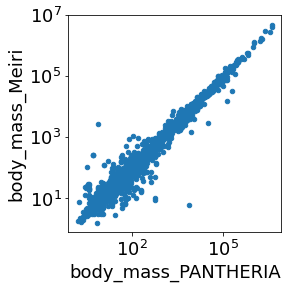

In [14]:
mammals_w_data = pd.read_csv(path_to_data+'all_species_list.csv')
mass_2021 = pd.read_csv(path_to_data+'Meiri et al. 2021 Appendix.csv')
mass_2021 = mass_2021[mass_2021.Class=='Mammalia']
mass_2021 = mass_2021[['binomial_(original files)','adult_body_mass (g)']]
mass_2021 = mammals_w_data.merge(mass_2021, left_on = 'binomial', right_on = 'binomial_(original files)', how = 'left')
mass_2021 = mass_2021.rename({'AdultBodyMass_g':'body_mass_PANTHERIA','adult_body_mass (g)':'body_mass_Meiri'}, axis = 1)

mass_2021.plot.scatter(x = 'body_mass_PANTHERIA',y = 'body_mass_Meiri', loglog = True).set_aspect('equal')


### Synanthrophic mammals

In [126]:
# to_infer = pd.read_csv(path_to_data+'species_to_infer_w_ranges.csv')
# common_names = pd.read_csv(path_to_data+'common_names.csv')
# suspected_synanthrophic = to_infer.merge(common_names, on = 'binomial')
# suspected_synanthrophic = suspected_synanthrophic.sort_values(by = 'Range_km_2', ascending = False)
# suspected_synanthrophic.iloc[0:50][['binomial','common_name','TrophicLevel','Range_km_2']]

In [127]:
# to_infer.sort_values(by = 'Range_km_2', ascending = False).iloc[0:40][['binomial','TrophicLevel','Range_km_2']]